# Úkol č. 1 - redukce dimenzionality a binární klasifikace

  * **Deadline je 22. 4. 2024, 23:59:59**, pokud odevzdáte úkol do 29. 4. 2024, 23:59:59, budete penalizování -12 body, pozdější odevzdání je bez bodu.
  * V rámci tohoto úkolu se musíte vypořádat s vysokou dimenzí problému a poté úspěšně aplikovat vhodný klasfikační model.
    
> **Úkoly jsou zadány tak, aby Vám daly prostor pro invenci. Vymyslet _jak přesně_ budete úkol řešit, je důležitou součástí zadání a originalita či nápaditost bude také hodnocena!**

Využívejte buňky typu `Markdown` k vysvětlování Vašeho postupu. Za nepřehlednost budou strhávány body.

## Zdroj dat

 * Zdrojem dat jsou soubory `train.csv` a `evaluate.csv`.
 * Jedná se o obrázky 28x28 pixelů ve stupních šedi, které byly získány z [Fashion Mnist datasetu](https://www.kaggle.com/datasets/zalando-research/fashionmnist).
 * Soubor `train.csv` obsahuje trénovací data.
 * Cílová (vysvětlovaná) proměnná se jmenuje **label**.
 * Soubor `evaluate.csv` obsahuje testovací data bez hodnot skutečných labelů.

## Pokyny k vypracování

**Body zadání**, za jejichž (poctivé) vypracování získáte **25 bodů**:
  * V notebooku načtěte data ze souboru `train.csv`. Vhodným způsobem si je rozdělte na podmnožiny, které Vám poslouží pro trénování, porovnávání modelů a následnou predikci výkonnosti finálního modelu.
  * Proveďte základní průzkum dat a svá pozorování diskutujte. Některé obrázky také zobrazte.
  * Postupně aplikujte modely **SVM**, **naivní Bayesův klasifikátor** a **LDA**, přičemž pro každý z nich:
      * Okomentujte vhodnost daného modelu pro daný typ úlohy.
      * Vyberte si hlavní hyperparametry k ladění (pokud model má hyperparametry) a najděte jejich nejlepší hodnoty.
      * Experimentujte se standardizací/normalizací dat.
      * U SVM vyzkoušejte alespoň dvě různé jádrové funkce.
      * Získané výsledky vždy řádně okomentujte.


  * Postupně aplikujte metody redukce dimenzionality PCA a LLE, přičemž pro každou z nich: 
      * Zopakujte předchozí kroky a pokuste modely vylepšit
      * Zkoumejte jaká dimenze je z hlediska výkonnosti finálního modelu nejlepší.
      * Získané výsledky vždy řádně okomentujte.
    
  * Ze všech zkoušených možností vyberte finální model a odhadněte, jakou přesnost můžete očekávat na nových datech, která jste doposud neměli k dispozici.
  
  * Nakonec načtěte vyhodnocovací data ze souboru`evaluate.csv`. Pomocí finálního modelu napočítejte predikce pro tyto data (vysvětlovaná proměnná v nich již není). Vytvořte soubor `results.csv`, ve kterém získané predikce uložíte do sloupce **label** a identifikátory do sloupce **ID**. Tento soubor též odevzdejte (uložte do projektu vedle notebooku).
   
   * Ukázka prvních řádků souboru `results.csv`:
  
```
ID,label
0,0
1,1
...
```

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-ML2/homeworks/index.html.
  * Vytvořte i csv soubor `results.csv` s predikcemi a uložte ho v rámci projektu vedle ipython notebooku.

#### Import potřebných balíčků

In [494]:
import pandas as pd
import numpy as np

import time

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import sklearn.metrics as metrics
from sklearn.metrics import roc_curve, auc

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

### Načtení a rozdělení dat

In [441]:
data = pd.read_csv('./train.csv')

**Provedeme rozdělení na trénovací, validační a testovací množinu:**

In [442]:
random_seed = 42

# Rozdělíme dataset tak, aby 70% tvořilo trénovací množinu a 30% zbytek
Xtrain, Xrest, ytrain, yrest = train_test_split(
    data.drop(columns=['label']), data['label'], test_size=0.3, random_state=random_seed
)

# Zbytek rozdělíme tak aby 15% tvořila validační množina a 15% testovací
Xval, Xtest, yval, ytest = train_test_split(
    Xrest, yrest, test_size=0.5, random_state=random_seed
)

Počty záznamů v jednotlivých množinách:

In [443]:
print(Xtrain.shape)
print(Xval.shape)
print(Xtest.shape)

(1680, 784)
(360, 784)
(360, 784)


### Základní průzkum dat

In [444]:
Xtrain.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1680 entries, 1067 to 860
Columns: 784 entries, pixel1 to pixel784
dtypes: int64(784)
memory usage: 10.1 MB


In [445]:
Xtrain.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
1067,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
792,0,0,0,0,0,0,0,0,0,0,...,189,68,0,0,0,0,0,0,0,0
2154,0,0,0,0,0,0,0,0,1,0,...,96,79,0,0,0,0,0,0,0,0
380,0,0,0,0,0,0,0,0,0,0,...,136,0,0,0,0,0,0,0,0,0
226,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0


* Může se hodit pro další průzkum

In [446]:
train = pd.concat([Xtrain,ytrain], axis=1)

**Zobrazme si pro lepší představu několik obrázků**

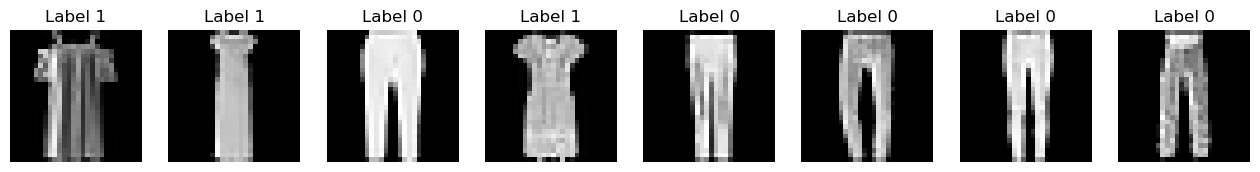

In [447]:
def plot_images(data, labels, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(16, 16))
    for i, ax in enumerate(axes):
        idx = np.random.randint(data.shape[0])
        
        img = data.iloc[idx].to_numpy().reshape(28, 28)
        
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        label = labels.iloc[idx]
        ax.set_title(f'Label {label}')

    plt.show()

plot_images(Xtrain, ytrain, 8)

**Rozdělení obrázků po třídách**

* Z grafu je patrné, že dataset je z pohledu výskytu různých tříd skoro vyvážený

In [448]:
unique, counts = np.unique(ytrain, return_counts=True)
print(unique)
unique = ['0', '1']

[0 1]


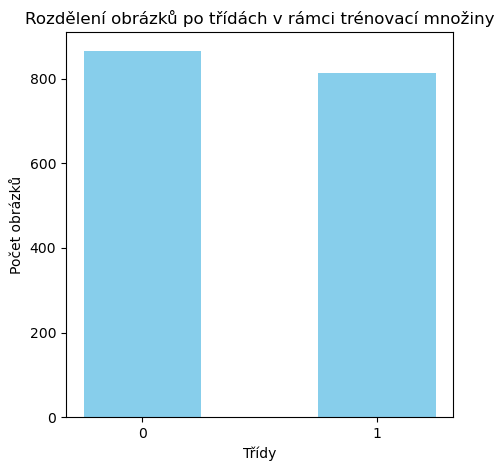

In [449]:
fig = plt.figure(figsize = (5, 5))
 
plt.bar(unique, counts, color ='skyblue', width=0.5)
 
plt.xlabel("Třídy")
plt.ylabel("Počet obrázků")
plt.title("Rozdělení obrázků po třídách v rámci trénovací množiny")
plt.show()

**Histogram intenzit pixelů:**

* Z histogramu je patrné, že většina pixelů je (skoro) černých, což je i vidět z vykreslených obrázků výše
* Dále jsou vidět intenzity a jim odpovídající počty pixelů v datasetu

/home/motlpetr/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/motlpetr/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


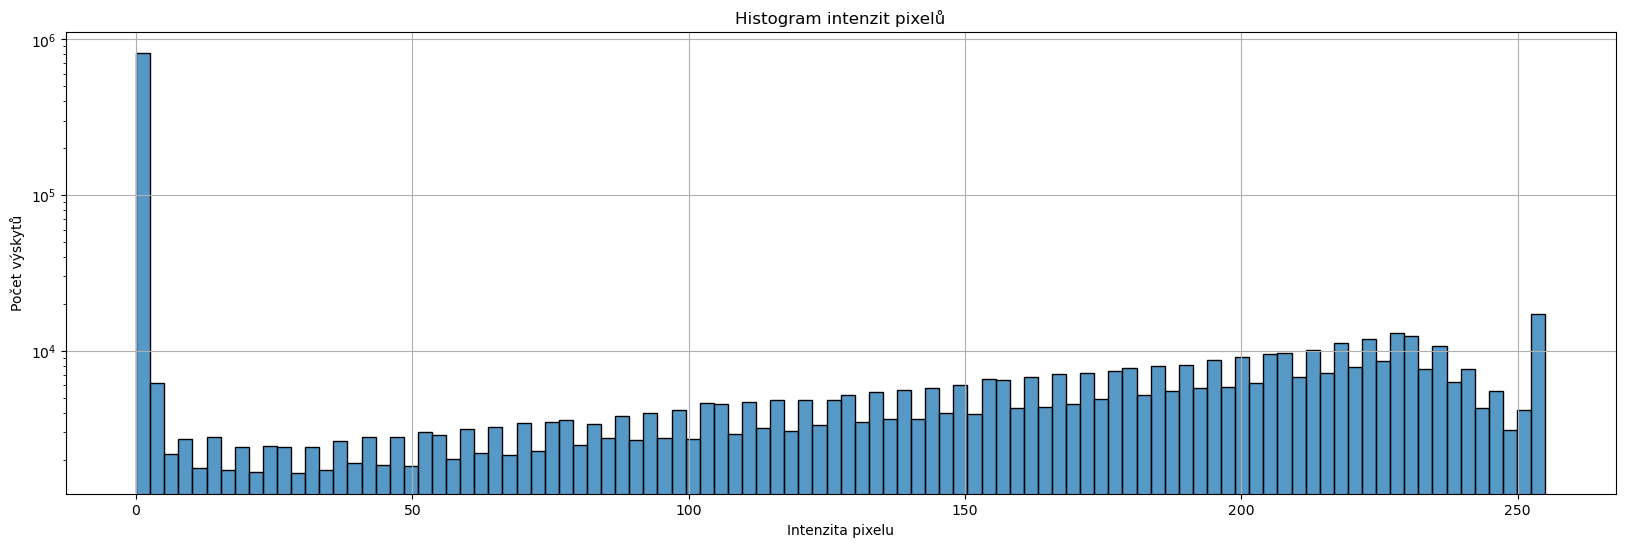

In [450]:
pixels = Xtrain.to_numpy().flatten()

plt.figure(figsize=(20, 6))
ax = sns.histplot(pixels,log_scale=(False, True))

plt.title('Histogram intenzit pixelů')
plt.xlabel('Intenzita pixelu')
plt.ylabel('Počet výskytů')
plt.grid(True)
plt.show()

**Základní statistiky:**

* Zkusme zprůměrovat hodnoty jednotlivých pixelů obrázků podle příslušnosti ke třídě a vykreslit si průměrný obrázek třídy 1 a třídy 0
* Z vykreslených obrázků jsou patrné rysy charakteristické pro jednotlivé třídy

In [451]:
label0_imgs = train[train.label == 0]
label1_imgs = train[train.label == 1]

label0_imgs = label0_imgs.drop(columns=['label'])
label1_imgs = label1_imgs.drop(columns=['label'])

In [452]:
mean_image_label0 = np.mean(label0_imgs, axis=0)
mean_image_label1 = np.mean(label1_imgs, axis=0)

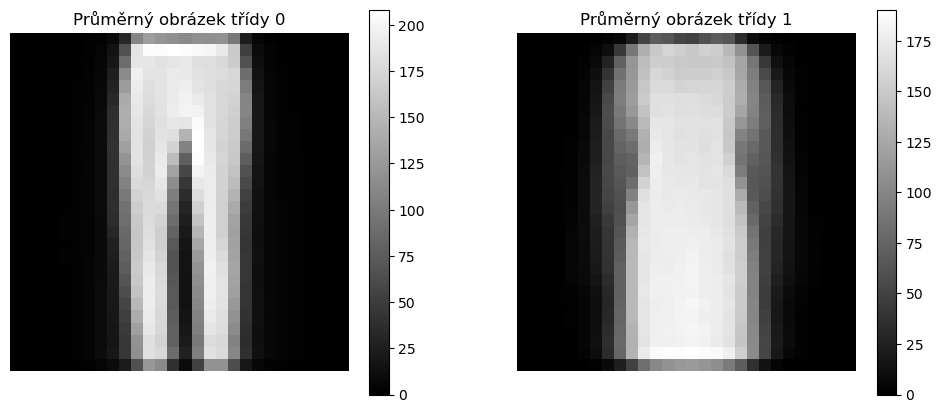

In [453]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(mean_image_label0.to_numpy().reshape(28, 28), cmap='gray')
plt.title('Průměrný obrázek třídy 0')
plt.colorbar()
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mean_image_label1.to_numpy().reshape(28, 28), cmap='gray')
plt.title('Průměrný obrázek třídy 1')
plt.colorbar()
plt.axis('off')

plt.show()

* Zkusme si ještě spočítat, jak moc se mezi sebou jednotlivé průměrné pixely obrázků rozdělených podle tříd navzájem liší a následně provést vizualizaci
* Vizualizace by mohla ukázat, které oblasti obrázků jsou klíčové pro rozlišení mezi našimi třídami
* Z obrázku je patrné, že se pixely nejvýše liší (z pohledu třídy 0) v oblasti oddělující nohavice kalhot

In [454]:
pixel_differences = np.abs(mean_image_label0 - mean_image_label1)

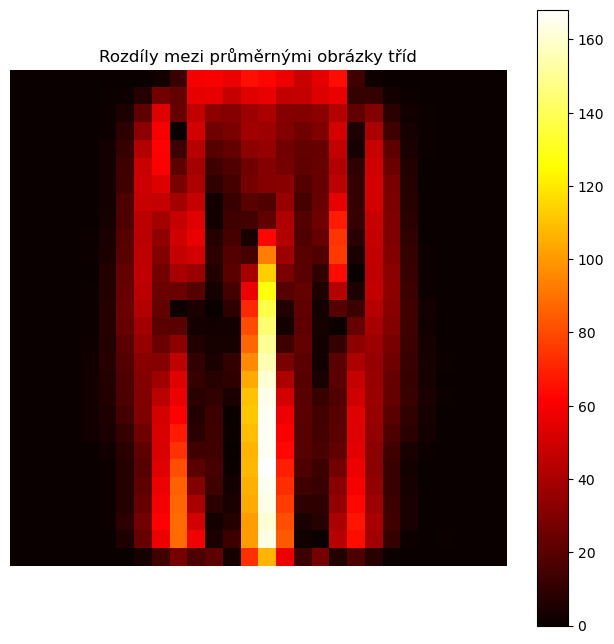

In [455]:
plt.figure(figsize=(8, 8))
plt.imshow(pixel_differences.to_numpy().reshape(28, 28), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Rozdíly mezi průměrnými obrázky tříd')
plt.axis('off')
plt.show()

### Aplikace modelů SVM, naivní Bayesův klasifikátor a LDA

* Pojďme postupně aplikovat jednotlivé modely
* Předpřipravme si zároveň standardizovaná a normalizovaná data

#### Příprava standardizovaných/normalizovaných dat

In [456]:
stand_scaler = StandardScaler()

Xtrain_standard = stand_scaler.fit_transform(Xtrain)
Xval_standard = stand_scaler.transform(Xval)
Xtest_standard = stand_scaler.transform(Xtest)


minmax_scaler = MinMaxScaler()

Xtrain_minmax = minmax_scaler.fit_transform(Xtrain)
Xval_minmax = minmax_scaler.transform(Xval)
Xtest_minmax = minmax_scaler.transform(Xtest)

#### Metoda podpůrných vektorů (SVM)

**Vhodnost modelu:**
* V našem případě se jedná o binární klasifikaci obrázků
* V našem datasetu máme celkem 784 příznaků pro každý obrázek reprezentující hodnoty jednotlivých pixelů, z čehož plyne že se jedná o prostor s vysokou dimenzí
* SVM funguje dobře i ve vysoce dimenzionálním prostoru, což je pro náš případ ideální

**Vyberte si hlavní hyperparametry k ladění (pokud model má hyperparametry) a najděte jejich nejlepší hodnoty:**
* Jako hyperparametry k ladění volme:
  * C - Regulační parametr
  * kernel - jádrová funkce
  * gamma

In [457]:
param_grid_svm = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'kernel': ['poly', 'rbf', 'sigmoid'],
    'gamma': np.arange (0.01, 1, 0.05)
}

comb_svm = ParameterGrid(param_grid_svm)

print("Počet kombinací:", len(comb_svm))

Počet kombinací: 480


* Nalezněme nejlepší kombinaci hyperparametrů pro náš model

In [403]:
svm_metric_values = []

st = time.time()

for comb in comb_svm:
    svm_clf_val = SVC(**comb)
    svm_clf_val.fit(Xtrain, ytrain)
    svm_metric_values.append(metrics.accuracy_score(yval, svm_clf_val.predict(Xval)))

et = time.time()
print(f"SVM - Ladění hyperparametrů: {et - st : .03f}s")

SVM - Ladění hyperparametrů:  165.271s


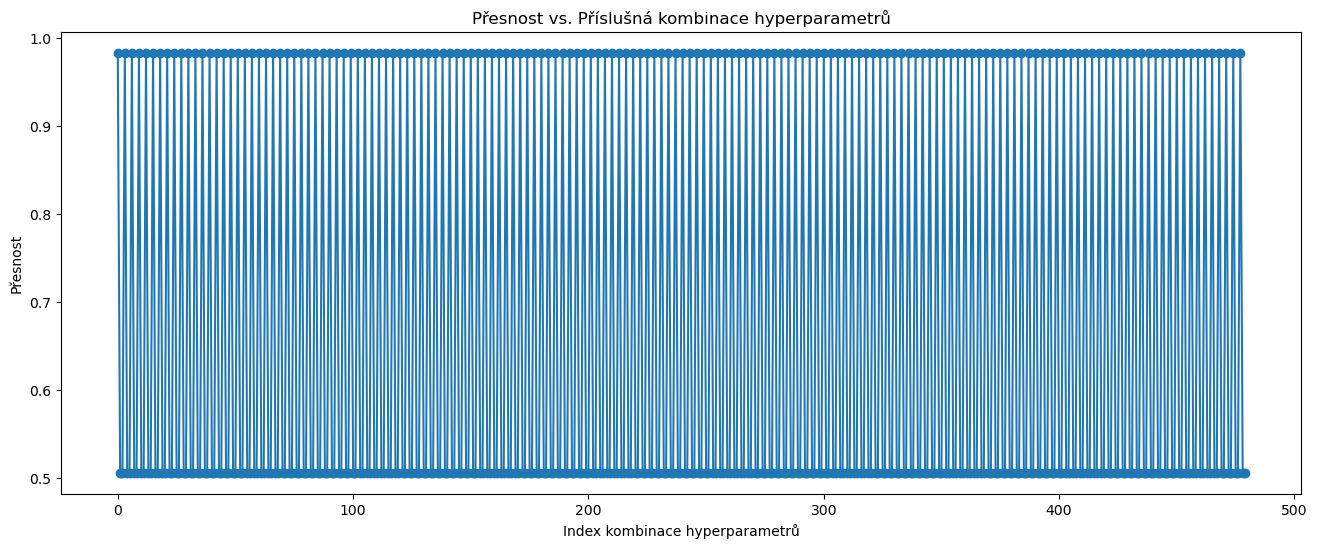

In [404]:
indices_svm = list(range(len(comb_svm)))

plt.figure(figsize=(16, 6))

plt.plot(indices_svm, svm_metric_values, marker='o', linestyle='-')
plt.xlabel('Index kombinace hyperparametrů')
plt.ylabel('Přesnost')
plt.title('Přesnost vs. Příslušná kombinace hyperparametrů')
plt.show()

In [405]:
best_params = comb_svm[np.argmax(svm_metric_values)]
display(best_params)

{'kernel': 'poly', 'gamma': 0.01, 'C': 0.0001}

* Model s nejlepší kombinací hyperparametrů

In [406]:
svm_clf_final = SVC(C=best_params['C'], kernel=best_params['kernel'], gamma=best_params['gamma'])
svm_clf_final.fit(Xtrain, ytrain)

SVC(C=0.0001, gamma=0.01, kernel='poly')

* ... docela pěkný výsledek

In [407]:
print('Accuracy score (validation): {0:.6f}'.format(metrics.accuracy_score(yval, svm_clf_final.predict(Xval))))

Accuracy score (validation): 0.983333


**Experimentujte se standardizací/normalizací dat:**
* Zkusme nyní využít naše standardizované/normalizované datasety, zdali bude patrný nějaký rozdíl

* Zkusme model natrénovat na standardizovaná data:

In [435]:
svm_metric_values_stand = []

st = time.time()

for comb in comb_svm:
    svm_clf_val_stand = SVC(**comb)
    svm_clf_val_stand.fit(Xtrain_standard, ytrain)
    svm_metric_values_stand.append(metrics.accuracy_score(yval, svm_clf_val_stand.predict(Xval_standard)))

et = time.time()
print(f"SVM - Ladění hyperparametrů: {et - st : .03f}s")

SVM - Ladění hyperparametrů:  138.577s


In [458]:
best_params_stand = comb_svm[np.argmax(svm_metric_values_stand)]
display(best_params_stand)

{'kernel': 'poly', 'gamma': 0.060000000000000005, 'C': 0.0001}

In [460]:
svm_clf_final_stand = SVC(**best_params_stand)
svm_clf_final_stand.fit(Xtrain_standard, ytrain)

SVC(C=0.0001, gamma=0.060000000000000005, kernel='poly')

In [461]:
print('Accuracy score (validation): {0:.6f}'.format(metrics.accuracy_score(yval, svm_clf_final_stand.predict(Xval_standard))))

Accuracy score (validation): 0.983333


* Zkusme model natrénovat na normalizovaná data:

In [412]:
svm_metric_values_norm = []

st = time.time()

for comb in comb_svm:
    svm_clf_val_norm = SVC(**comb)
    svm_clf_val_norm.fit(Xtrain_minmax, ytrain)
    svm_metric_values_norm.append(metrics.accuracy_score(yval, svm_clf_val_norm.predict(Xval_minmax)))

et = time.time()
print(f"SVM - Ladění hyperparametrů: {et - st : .03f}s")

SVM - Ladění hyperparametrů:  148.431s


In [413]:
best_params_norm = comb_svm[np.argmax(svm_metric_values_norm)]

In [462]:
svm_clf_final_norm = SVC(**best_params_norm)
svm_clf_final_norm.fit(Xtrain_minmax, ytrain)

SVC(C=0.0001, gamma=0.51, kernel='poly')

In [463]:
print('Accuracy score (validation): {0:.6f}'.format(metrics.accuracy_score(yval, svm_clf_final_norm.predict(Xval_minmax))))

Accuracy score (validation): 0.991667


* Vidíme, že se accuracy po použití standardizace ani normalizace nezlepšila

#### Naivní Bayesův klasifikátor

**Vhodnost modelu:**
* Model je opět rezistentní proti problémům s dimenzionalitou, což z něj může činit vhodný model pro naši úlohu

**Vyberte si hlavní hyperparametry k ladění (pokud model má hyperparametry) a najděte jejich nejlepší hodnoty:**
* Jelikož Naivní bayesův klasifikátor v podstatě nemá hyperparametry k ladění, vyzkoušíme místo toho různé modely Naivního bayese
  * Gaussian model
  * Bernoulli model

In [416]:
gaussian_clf = GaussianNB()

In [417]:
gaussian_clf.fit(Xtrain, ytrain)
print('Accuracy score (validation): {0:.6f}'.format(metrics.accuracy_score(yval, gaussian_clf.predict(Xval))))

Accuracy score (validation): 0.927778


In [418]:
bernoulli_clf = BernoulliNB(binarize=128)

In [419]:
bernoulli_clf.fit(Xtrain, ytrain)
print('Accuracy score (validation): {0:.6f}'.format(metrics.accuracy_score(yval, bernoulli_clf.predict(Xval))))

Accuracy score (validation): 0.936111


* Vidíme, že výsledky nejsou vůbec špatné, avšak horší než u SVM

**Experimentujte se standardizací/normalizací dat:**

* Zkusme Gaussian model natrénovat na standardizovaná data:

In [420]:
gaussian_clf_stand = GaussianNB()
gaussian_clf_stand.fit(Xtrain_standard, ytrain)
print('Accuracy score (validation): {0:.6f}'.format(metrics.accuracy_score(yval, gaussian_clf_stand.predict(Xval_standard))))

Accuracy score (validation): 0.875000


* Zkusme Gaussian model natrénovat na normalizovaná data:

In [421]:
gaussian_clf_norm = GaussianNB()
gaussian_clf_norm.fit(Xtrain_minmax, ytrain)
print('Accuracy score (validation): {0:.6f}'.format(metrics.accuracy_score(yval, gaussian_clf_norm.predict(Xval_minmax))))

Accuracy score (validation): 0.905556


* Standardizace ani normalizace nám nepomohla

#### Lineární diskriminační analýza (LDA)

**Vhodnost modelu:**
* LDA může být účinná pro binární klasifikaci obrázků v našem datasetu, pokud data dobře odpovídají předpokladům lineární separability

In [422]:
lda_clf = LinearDiscriminantAnalysis()

In [423]:
lda_clf.fit(Xtrain, ytrain)
print('Accuracy score (validation): {0:.6f}'.format(metrics.accuracy_score(yval, lda_clf.predict(Xval))))

Accuracy score (validation): 0.936111


* Výsledek opět není špatný, avšak SVM vyhrává

**Experimentujte se standardizací/normalizací dat:**

* Zkusme model natrénovat na standardizovaná data:

In [424]:
lda_clf_stand = LinearDiscriminantAnalysis()
lda_clf_stand.fit(Xtrain_standard, ytrain)
print('Accuracy score (validation): {0:.6f}'.format(metrics.accuracy_score(yval, lda_clf_stand.predict(Xval_standard))))

Accuracy score (validation): 0.936111


* Zkusme model natrénovat na normalizovaná data:

In [425]:
lda_clf_norm = LinearDiscriminantAnalysis()
lda_clf_norm.fit(Xtrain_minmax, ytrain)
print('Accuracy score (validation): {0:.6f}'.format(metrics.accuracy_score(yval, lda_clf_norm.predict(Xval_minmax))))

Accuracy score (validation): 0.936111


* Vidíme že standardizace ani normalizace neměla na výsledek vůbec žádný vliv

### Metody redukce dimenzionality PCA a LLE

* Aplikujme postupně PCA a LLE pro redukci dimenzionality a zkusme na nich otestovat naše modely
* Pro SVM si vzhledem k výpočetní náročnosti zvolme méně hyperparametrů k ladění

In [426]:
param_grid_svm_simple = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'kernel': ['poly', 'rbf', 'sigmoid']
}

comb_svm_simple = ParameterGrid(param_grid_svm_simple)

print("Počet kombinací:", len(comb_svm_simple))

Počet kombinací: 24


#### Analýza hlavních komponent (PCA)

In [427]:
svm_acc_pca = []
bayes_acc_pca = []
lda_acc_pca = []

st = time.time()

for n in range(2, 200, 5):
    pca = PCA(n_components=n)
    Xtrain_pca = pca.fit_transform(Xtrain)
    Xval_pca = pca.transform(Xval)

    svm_metrics = []

    for comb in comb_svm_simple:
        svm_clf_val = SVC(**comb)
        svm_clf_val.fit(Xtrain_pca, ytrain)
        svm_metrics.append(metrics.accuracy_score(yval, svm_clf_val.predict(Xval_pca)))

    best_params = comb_svm_simple[np.argmax(svm_metrics)]
    
    svm_clf_final = SVC(**best_params)
    svm_clf_final.fit(Xtrain_pca, ytrain)
    svm_acc_pca.append(metrics.accuracy_score(yval, svm_clf_final.predict(Xval_pca)))

    gaussian_clf = GaussianNB()
    gaussian_clf.fit(Xtrain_pca, ytrain)
    bayes_acc_pca.append(metrics.accuracy_score(yval, gaussian_clf.predict(Xval_pca)))

    lda_clf = LinearDiscriminantAnalysis()
    lda_clf.fit(Xtrain_pca, ytrain)
    lda_acc_pca.append(metrics.accuracy_score(yval, lda_clf.predict(Xval_pca)))

et = time.time()
print(f"Celkový čas: {et - st : .03f}s")

Celkový čas:  71.754s


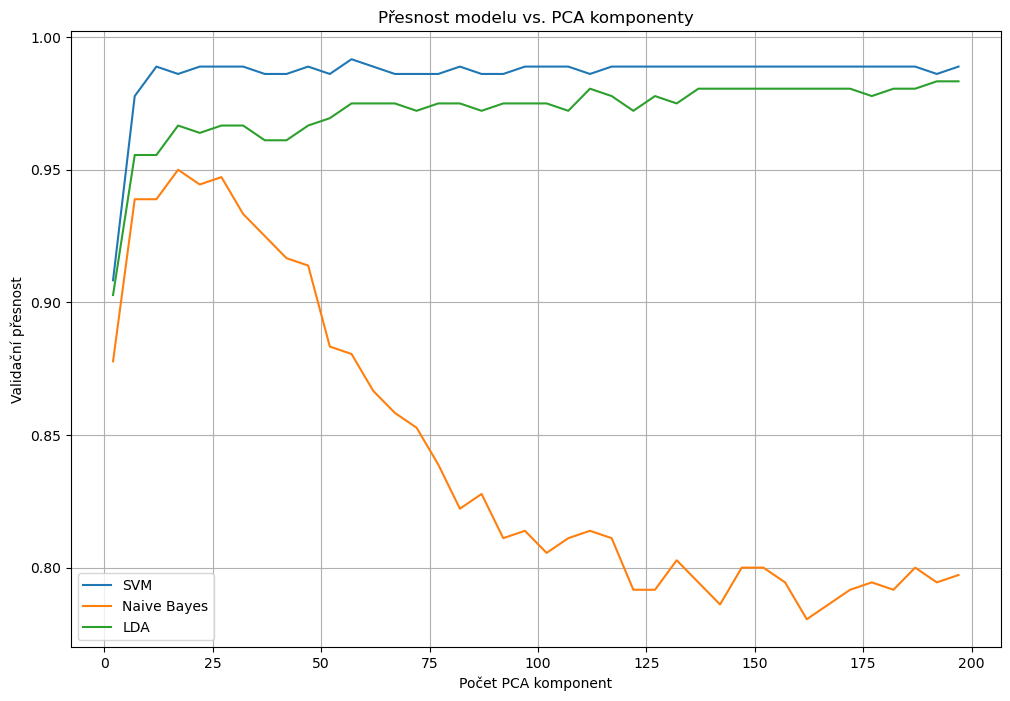

In [428]:
plt.figure(figsize=(12, 8))
plt.plot(range(2, 200, 5), svm_acc_pca, label='SVM')
plt.plot(range(2, 200, 5), bayes_acc_pca, label='Naive Bayes')
plt.plot(range(2, 200, 5), lda_acc_pca, label='LDA')
plt.xlabel('Počet PCA komponent')
plt.ylabel('Validační přesnost')
plt.title('Přesnost modelu vs. PCA komponenty')
plt.legend()
plt.grid(True)
plt.show()

**Pojďme zjistit s kolika přesně komponentami v případě PCA jsou jednotlivé modely nejlepší a vypišme jejich přesnost**

In [429]:
max_index_svm_pca = np.argmax(svm_acc_pca)
max_index_bayes_pca = np.argmax(bayes_acc_pca)
max_index_lda_pca = np.argmax(lda_acc_pca)

print("Nejlepší hodnoty:")
print(f"SVM, počet hlavních komponent: { max_index_svm_pca*5 +2 }, validační přesnost {svm_acc_pca[max_index_svm_pca] : .06f}")
print(f"SVM - nejlepší hyperparametry { comb_svm_simple[max_index_svm_pca] }")
print(f"Naive Bayes, počet hlavních komponent: { max_index_bayes_pca*5 +2 }, validační přesnost {bayes_acc_pca[max_index_bayes_pca] : .06f}")
print(f"LDA, počet hlavních komponent: { max_index_lda_pca*5 +2 }, validační přesnost {lda_acc_pca[max_index_lda_pca] : .06f}")

Nejlepší hodnoty:
SVM, počet hlavních komponent: 57, validační přesnost  0.991667
SVM - nejlepší hyperparametry {'kernel': 'sigmoid', 'C': 0.1}
Naive Bayes, počet hlavních komponent: 17, validační přesnost  0.950000
LDA, počet hlavních komponent: 192, validační přesnost  0.983333


#### Lokálně lineární vnoření (LLE)

In [430]:
param_grid_lle = {
    'n_components': range(2, 200, 5),
    'n_neighbors': [5, 10, 30],
    'n_jobs': [-1]
}

combs_lle = ParameterGrid(param_grid_lle)

print("Počet kombinací:", len(combs_lle))

Počet kombinací: 120


In [431]:
svm_acc_lle = []
bayes_acc_lle = []
lda_acc_lle = []

st = time.time()

for comb in combs_lle:
    lle = LocallyLinearEmbedding(**comb)
    Xtrain_lle = lle.fit_transform(Xtrain)
    Xval_lle = lle.transform(Xval)

    svm_metrics = []

    for comb in comb_svm_simple:
        svm_clf_val = SVC(**comb)
        svm_clf_val.fit(Xtrain_lle, ytrain)
        svm_metrics.append(metrics.accuracy_score(yval, svm_clf_val.predict(Xval_lle)))

    best_params = comb_svm_simple[np.argmax(svm_metrics)]
    
    svm_clf_final = SVC(**best_params)
    svm_clf_final.fit(Xtrain_lle, ytrain)
    svm_acc_lle.append(metrics.accuracy_score(yval, svm_clf_final.predict(Xval_lle)))

    gaussian_clf = GaussianNB()
    gaussian_clf.fit(Xtrain_lle, ytrain)
    bayes_acc_lle.append(metrics.accuracy_score(yval, gaussian_clf.predict(Xval_lle)))

    lda_clf = LinearDiscriminantAnalysis()
    lda_clf.fit(Xtrain_lle, ytrain)
    lda_acc_lle.append(metrics.accuracy_score(yval, lda_clf.predict(Xval_lle)))

et = time.time()
print(f"Celkový čas: {et - st : .03f}s")

Celkový čas:  323.930s


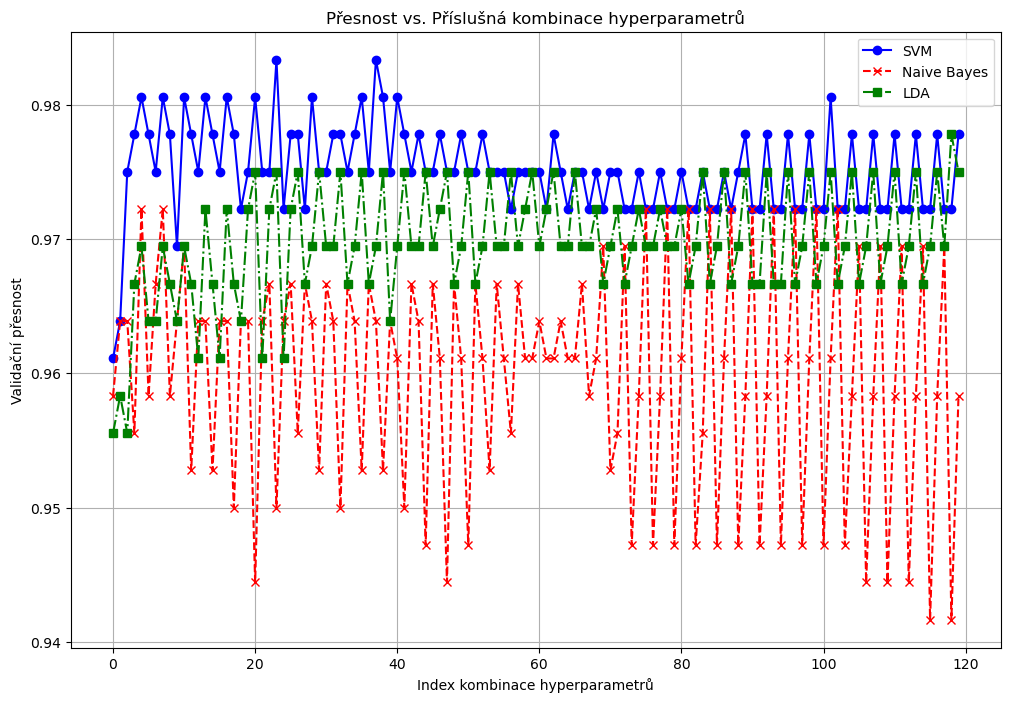

In [432]:
indices = list(range(len(combs_lle)))
plt.figure(figsize=(12, 8))

plt.plot(indices, svm_acc_lle, marker='o', linestyle='-', color='b', label='SVM')
plt.plot(indices, bayes_acc_lle, marker='x', linestyle='--', color='r', label='Naive Bayes')
plt.plot(indices, lda_acc_lle, marker='s', linestyle='-.', color='g', label='LDA')

plt.xlabel('Index kombinace hyperparametrů')
plt.ylabel('Validační přesnost')
plt.title('Přesnost vs. Příslušná kombinace hyperparametrů')
plt.legend()
plt.grid(True)
plt.show()

**Pojďme zjistit s kolika přesně komponentami a sousedy v případě LLE jsou jednotlivé modely nejlepší a vypišme jejich přesnost**

In [433]:
max_ind_svm_lle = np.argmax(svm_acc_lle)
max_ind_bayes_lle = np.argmax(bayes_acc_lle)
max_ind_lda_lle = np.argmax(lda_acc_lle)

best_svm_lle = combs_lle[max_ind_svm_lle]
best_bayes_lle = combs_lle[max_ind_bayes_lle]
best_lda_lle = combs_lle[max_ind_lda_lle]

print("Nejlepší hodnoty:")
print(f"SVM, počet hlavních komponent: { best_svm_lle['n_components'] }, sousedů { best_svm_lle['n_neighbors'] }, Validační přesnost { svm_acc_lle[max_ind_svm_lle] : .06f}")
print(f"SVM - nejlepší hyperparametry { comb_svm_simple[max_ind_svm_lle] }")
print(f"Bayes, počet hlavních komponent: { best_bayes_lle['n_components'] }, sousedů { best_bayes_lle['n_neighbors'] }, Validační přesnost { bayes_acc_lle[max_ind_bayes_lle] : .06f}")
print(f"LDA, počet hlavních komponent: { best_lda_lle['n_components'] }, sousedů { best_lda_lle['n_neighbors'] }, Validační přesnost { lda_acc_lle[max_ind_lda_lle] : .06f} ")

Nejlepší hodnoty:
SVM, počet hlavních komponent: 37, sousedů 30, Validační přesnost  0.983333
SVM - nejlepší hyperparametry {'kernel': 'sigmoid', 'C': 1000}
Bayes, počet hlavních komponent: 7, sousedů 10, Validační přesnost  0.972222
LDA, počet hlavních komponent: 197, sousedů 10, Validační přesnost  0.977778 


### Výběr finálního modelu a odhad přesnosti

#### Výběr finálního modelu
* Uvažme nejlepší kandidáty pro finální model na základě přechozích výsledků a vyberme z nich nejlepší
* Vzhledem k přechozím přesnostem modelů volme jako kandidátní modely následující
  * SVM po aplikaci PCA
  * SVM po aplikaci minmax scaleru
  * Bayes po aplikaci LLE
  * LDA po aplikaci PCA
  * LDA po aplikaci LLE

* Spočtěme pro každý z kandidátních modelů ROC, AUC a F1 skóre

In [486]:
# Natrénujme si nejprve kandidátní modely s předchozími nejlepšími hyperparametry
pca_svm = PCA(n_components=(max_index_svm_pca*5 + 2))
Xtrain_pca_s = pca_svm.fit_transform(Xtrain)
Xval_pca_s = pca_svm.transform(Xval)

pca_lda = PCA(n_components=(max_index_lda_pca*5 + 2))
Xtrain_pca_l = pca_lda.fit_transform(Xtrain)
Xval_pca_l = pca_lda.transform(Xval)

lle_bayes = LocallyLinearEmbedding(**best_bayes_lle)
Xtrain_lle_b = lle_bayes.fit_transform(Xtrain)
Xval_lle_b = lle_bayes.transform(Xval)

lle_lda = LocallyLinearEmbedding(**best_lda_lle)
Xtrain_lle_l = lle_lda.fit_transform(Xtrain)
Xval_lle_l = lle_lda.transform(Xval)

svm_minmax_best = SVC(**best_params_norm, probability=True)
svm_pca_best = SVC(**comb_svm_simple[max_index_svm_pca], probability=True)
bayes_lle_best = GaussianNB()
lda_pca_best = LinearDiscriminantAnalysis()
lda_lle_best = LinearDiscriminantAnalysis()

svm_minmax_best.fit(Xtrain_minmax, ytrain)
svm_pca_best.fit(Xtrain_pca_s, ytrain)
bayes_lle_best.fit(Xtrain_lle_b, ytrain)
lda_pca_best.fit(Xtrain_pca_l, ytrain)
lda_lle_best.fit(Xtrain_lle_l, ytrain)

LinearDiscriminantAnalysis()

In [487]:
print('Accuracy score SVM (MinMax) (validation): {0:.6f}'.format(metrics.accuracy_score(yval, svm_minmax_best.predict(Xval_minmax))))
print('Accuracy score SVM (PCA) (validation): {0:.6f}'.format(metrics.accuracy_score(yval, svm_pca_best.predict(Xval_pca_s))))
print('Accuracy score Bayes (LLE) (validation): {0:.6f}'.format(metrics.accuracy_score(yval, bayes_lle_best.predict(Xval_lle_b))))
print('Accuracy score LDA (PCA) (validation): {0:.6f}'.format(metrics.accuracy_score(yval, lda_pca_best.predict(Xval_pca_l))))
print('Accuracy score LDA (LLE) (validation): {0:.6f}'.format(metrics.accuracy_score(yval, lda_lle_best.predict(Xval_lle_l))))

Accuracy score SVM (MinMax) (validation): 0.991667
Accuracy score SVM (PCA) (validation): 0.955556
Accuracy score Bayes (LLE) (validation): 0.972222
Accuracy score LDA (PCA) (validation): 0.977778
Accuracy score LDA (LLE) (validation): 0.977778


In [488]:
print(f'F1 score SVM (MinMax) (validation): {metrics.f1_score(yval, svm_minmax_best.predict(Xval_minmax)):.4f}')
print(f'F1 score SVM (PCA) (validation): {metrics.f1_score(yval, svm_pca_best.predict(Xval_pca_s)):.4f}')
print(f'F1 score SVM Bayes (LLE) (validation): {metrics.f1_score(yval, bayes_lle_best.predict(Xval_lle_b)):.4f}')
print(f'F1 score SVM LDA (PCA) (validation): {metrics.f1_score(yval, lda_pca_best.predict(Xval_pca_l)):.4f}')
print(f'F1 score SVM LDA (LLE) (validation): {metrics.f1_score(yval, lda_lle_best.predict(Xval_lle_l)):.4f}')

F1 score SVM (MinMax) (validation): 0.9916
F1 score SVM (PCA) (validation): 0.9563
F1 score SVM Bayes (LLE) (validation): 0.9727
F1 score SVM LDA (PCA) (validation): 0.9779
F1 score SVM LDA (LLE) (validation): 0.9779


In [489]:
y_prob_minmax = svm_minmax_best.predict_proba(Xval_minmax)[:, 1]
y_prob_pca = svm_pca_best.predict_proba(Xval_pca_s)[:, 1]
y_prob_bayes = bayes_lle_best.predict_proba(Xval_lle_b)[:, 1]
y_prob_lda_pca = lda_pca_best.predict_proba(Xval_pca_l)[:, 1]
y_prob_lda_lle = lda_lle_best.predict_proba(Xval_lle_l)[:, 1]

In [495]:
def plot_roc_curve(y_true, y_prob, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic: {model_name}')
    plt.legend(loc="lower right")
    plt.show()

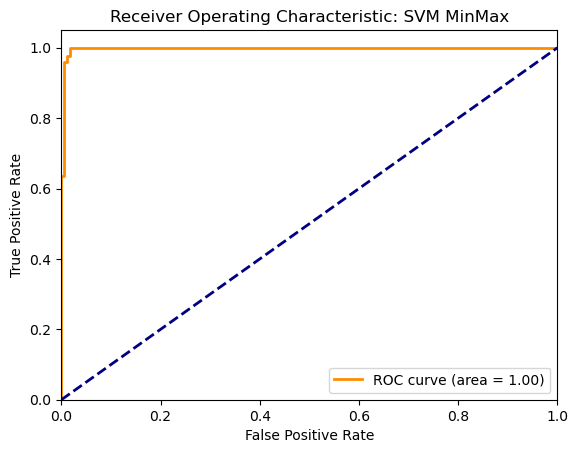

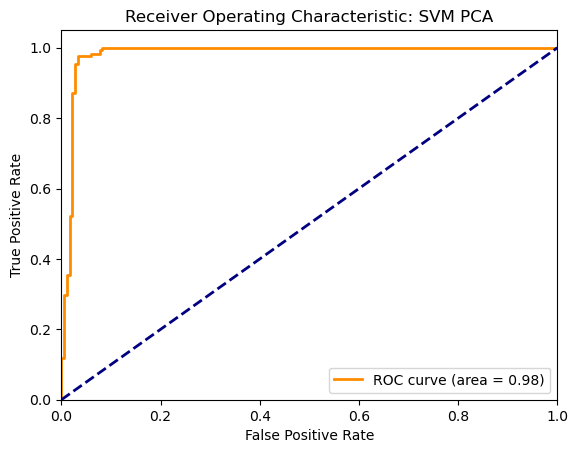

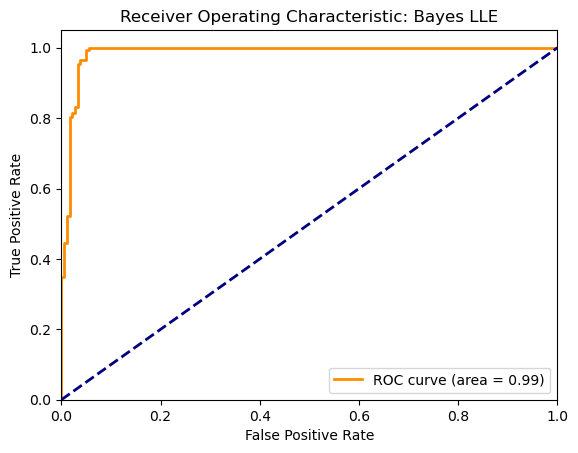

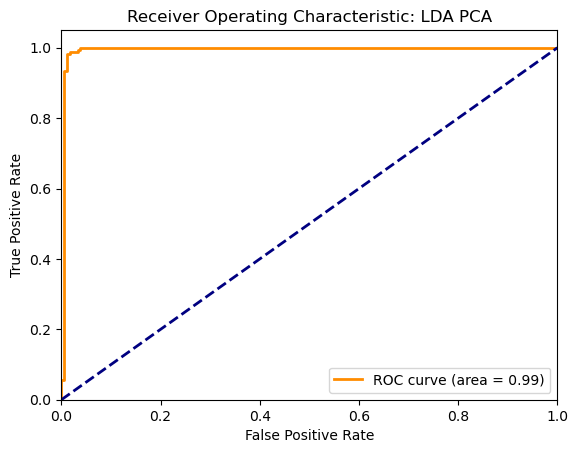

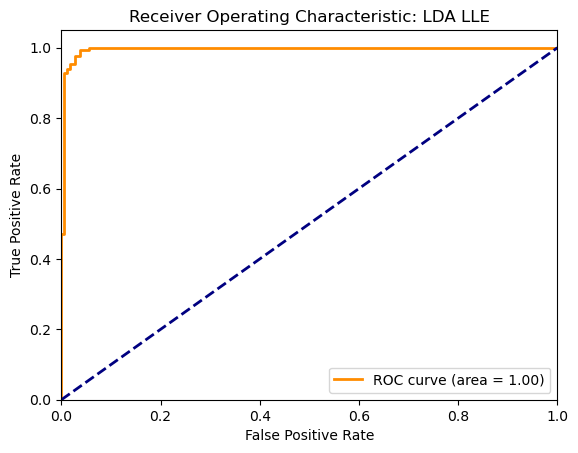

In [496]:
plot_roc_curve(yval, y_prob_minmax, "SVM MinMax")
plot_roc_curve(yval, y_prob_pca, "SVM PCA")
plot_roc_curve(yval, y_prob_bayes, "Bayes LLE")
plot_roc_curve(yval, y_prob_lda_pca, "LDA PCA")
plot_roc_curve(yval, y_prob_lda_lle, "LDA LLE")

**Na základě předchozích charakteristik volme jako nejlepší model SVM po normalizaci dat pomocí MinMax scaleru**

#### Odhad přesnosti

* Vypadá to na docela slušný odhad přesnosti

In [506]:
print('Accuracy score (test): {0:.6f}'.format(metrics.accuracy_score(ytest, svm_minmax_best.predict(Xtest_minmax))))

print(f'F1 score (test): {metrics.f1_score(ytest, svm_minmax_best.predict(Xtest_minmax)):.4f}')

Accuracy score (test): 0.969444
F1 score (test): 0.9679


### Finální predikce

In [507]:
eval = pd.read_csv('./evaluate.csv')

ids = eval['ID']
eval_data = eval.drop('ID', axis=1)

In [508]:
eval_norm = minmax_scaler.transform(eval_data)

In [509]:
predictions = svm_minmax_best.predict(eval_norm)

In [510]:
results = pd.DataFrame({'ID': ids, 'label': predictions})
results.to_csv('./results.csv', index=False)